This project will analyze the top posts of the politics subreddit - namely, sentiment analysis of the titles and top comments, frequency of tokens in positive/negative titles, determine the top 10 used sources, and analysis of the relationship between the top comment score of a post and the post's total comments. This project utilizes the PRAW, pandas, matplotlib, seaborn, pprint, nltk, Counter and math libraries and creates a custom Comment class.

Because this project was done in Google Colaboratory, we first need to install PRAW. Because scatterplot is in the new seaborn version update, install seaborn as well.

In [0]:
!pip install praw
!pip install -U seaborn

In [0]:
import praw
from pprint import pprint
import pandas as pd
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import math
from collections import Counter

First, connect to the reddit API via PRAW and iterate through all of the top posts of politics and add their titles and sources to a set of titles and sources respectively. 

In [0]:
reddit = praw.Reddit(client_id = 'CLIENT_ID',
                     client_secret = 'CLIENT_SECRET',
                     username='USERNAME',
                     password='PASSWORD',
                     user_agent='USER_AGENT')

politics = reddit.subreddit('politics')
top_posts = politics.top(limit=None)

titles = set()
sources = set()

for post in top_posts:
  titles.add(post.title)
  sources.add(post.url)
  
print(len(titles))

998


Utilizing the SentimentIntensityAnalyzer in nltk, for each of the titles, append each sentiment dictionary (polarity scores) to a results list.

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in titles:
    pol_score = sia.polarity_scores(line)
    pol_score['title'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': -0.7906,
  'neg': 0.467,
  'neu': 0.533,
  'pos': 0.0,
  'title': "Scarborough to Trump: 'Poor leadership' is golfing while Americans die"},
 {'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'title': 'Poll: 78 Percent think Russian investigation should be independent'},
 {'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'title': 'Bill would keep Trump off 2020 ballot unless he releases his tax returns'}]


Transform the results list into a pandas dataframe.

In [0]:
df_titles = pd.DataFrame.from_records(results)
df_titles.head()

,compound,neg,neu,pos,title
0,0.0000,0.000,1.000,0.000,Rachel Maddow says she has Trump's tax returns
1,-0.5574,0.247,0.753,0.000,Trump fired Sally Yates the day she offered ev...
2,-0.2960,0.109,0.891,0.000,Brett Kavanaugh has been accused of sexual mis...
3,0.0000,0.000,1.000,0.000,Ted Nugent once said Obama should ‘suck on my ...
4,0.4939,0.000,0.758,0.242,Democrats save arts funding for NPR and PBS fr...


The compound value scores the sentiment and ranges from -1 (Extremely Negative) to 1 (Extremely Positive). For the purposes of this project, compound values greater than 0.2 will be labeled as positive (1) and values less than -0.2 as negative (-1). Posts that fall between -0.2 and 0.2 will be labeled as neutral (0).

In [0]:
df_titles['label'] = 0
df_titles.loc[df_titles['compound'] > 0.2, 'label'] = 1
df_titles.loc[df_titles['compound'] < -0.2, 'label'] = -1
df_titles.head()

,compound,neg,neu,pos,title,label
0,0.0000,0.000,1.000,0.000,Rachel Maddow says she has Trump's tax returns,0
1,-0.5574,0.247,0.753,0.000,Trump fired Sally Yates the day she offered ev...,-1
2,-0.2960,0.109,0.891,0.000,Brett Kavanaugh has been accused of sexual mis...,-1
3,0.0000,0.000,1.000,0.000,Ted Nugent once said Obama should ‘suck on my ...,0
4,0.4939,0.000,0.758,0.242,Democrats save arts funding for NPR and PBS fr...,1


Examples of positive and negative titles.

In [0]:
df_titles_labeled = df_titles[['title', 'label']]
df_titles_labeled.to_csv('reddit_titles_labels.csv', mode='a', encoding='utf-8', index=False)

print("Positive titles:\n")
pprint(list(df_titles[df_titles['label'] == 1].title)[:5], width=200)

print("\nNegative titles:\n")
pprint(list(df_titles[df_titles['label'] == -1].title)[:5], width=200)

Positive titles:

['Democrats save arts funding for NPR and PBS from Donald Trump',
 'Majority says Election Day should be a federal holiday, poll finds',
 'Obama Endorses Idea of National Voting Holiday',
 "Findings that Russia meddled to help Trump beat Clinton were 'accurate and on point': Senate intel panel",
 'Kyrsten Sinema wins, will become the first Democratic senator from Arizona in a quarter century']

Negative titles:

['Trump fired Sally Yates the day she offered evidence Flynn was compromised',
 "Brett Kavanaugh has been accused of sexual misconduct with a woman in a letter that's been passed to the FBI: Report",
 "Poll: Majority says Trump not 'fit to serve as president'",
 '37 of 38 economists said the GOP tax plans would grow the debt. The 38th misread the question.',
 "Trump's EPA Greenlights a Nasty Chemical. A Month Later, It Poisons a Bunch of Farmworkers."]


Calculate the total count of neutral, negative, and positive post titles there are and then normalize them.

In [0]:
print(df_titles.label.value_counts())

print(df_titles.label.value_counts(normalize=True) * 100)

 0    417
-1    359
 1    222
Name: label, dtype: int64
 0    41.783567
-1    35.971944
 1    22.244489
Name: label, dtype: float64


Plot a bar chart with the normalized counts of the polarity post titles. Interestingly, there are more neutral titles than positive or negative titles. However, there are approximately 15% more negative titles than positive titles.

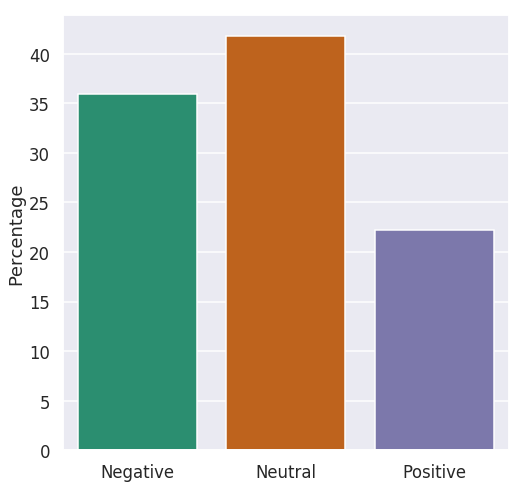

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df_titles.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

To calculate the most frequently used words in post titles, first I used nltk's tokenizer and downloaded stopwords (words that don't contain much information/sentiment and should be removed) from nltk's library. Then I defined a function that takes in a list of titles and lowercases, tokenizes, and removes stopwords from each title.

In [0]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def process_text(titles):
    tokens = []
    for line in titles:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

Tokenize all of the positive titles and show the top 20 most frequently used tokens.

In [0]:
pos_lines = list(df_titles[df_titles_labeled.label == 1].title)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('trump', 112),
 ('donald', 22),
 ('says', 20),
 ('russia', 17),
 ('house', 17),
 ('bill', 14),
 ('special', 13),
 ('election', 12),
 ('mueller', 12),
 ('obama', 11),
 ('campaign', 11),
 ('day', 10),
 ('top', 10),
 ('white', 10),
 ('justice', 10),
 ('care', 10),
 ('senate', 9),
 ('intelligence', 9),
 ('counsel', 9),
 ('russian', 9)]

Plot the frequency distribution of the positive tokens. From the plot, we can see that only a minority of tokens are used frequently and the majority of tokens are used less frequently.

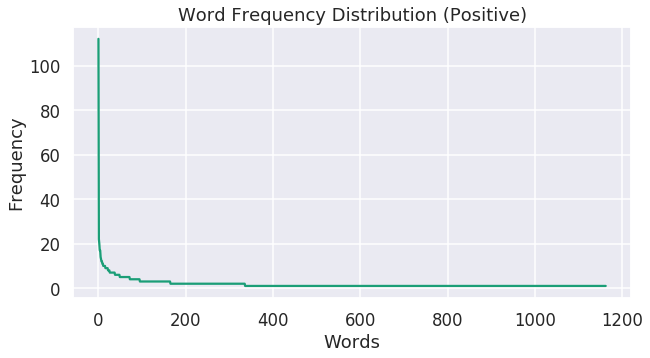

In [0]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

Tokenize all of the negative titles and show the top 20 most frequently used tokens. From this, we see that Trump and the Mueller investigation dominate the news cycle so much so that they are both in the most frequently used positive and negative titles. Notably, 'assault' and 'sexual' are frequent negative tokens that do not appear in the frequent positive token list.

In [0]:
neg_lines = list(df_titles_labeled[df_titles_labeled.label == -1].title)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 194),
 ('donald', 34),
 ('says', 27),
 ('white', 22),
 ('president', 21),
 ('house', 20),
 ('us', 18),
 ('mueller', 16),
 ('fraud', 15),
 ('obama', 14),
 ('russia', 13),
 ('vote', 12),
 ('russian', 12),
 ('assault', 12),
 ('people', 12),
 ('sexual', 11),
 ('gop', 11),
 ('million', 11),
 ('u', 11),
 ('report', 10)]

Plot the frequency distribution of the negative tokens. Similar to the case of positive tokens, from the plot, we can see that only a minority of tokens are used frequently and the majority of tokens are used less frequently.



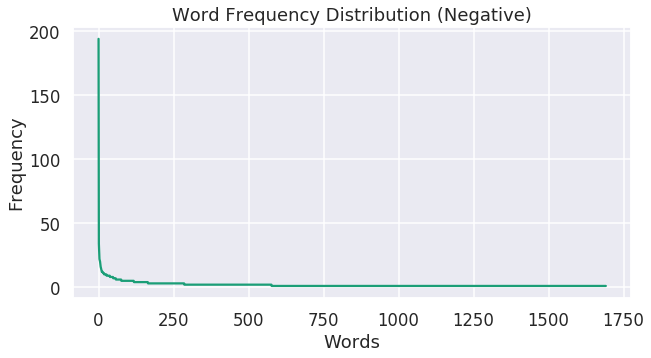

In [0]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

Each post links a url source that contains a HTTP protocol, so I can first split the url strings on the "//" ending the protocol. However, not all urls contain "www" so conditionally split if the remaining string contains "www." The 4 most common top-level domains are  ".com," ".co" (UK sources), ".org", and ".gov". Using casework, split the url strings by casing on the top-level domains to get the subdomains (the websites). The remaining sample of sources remains large - 995.

In [0]:
sources_first_split = []
sources_second_split = []
sources_third_split = []

for source in sources:
  sources_first_split.append(source.split("//")[1])

for source in sources_first_split:
  if "www." in source:
    sources_second_split.append(source.split("www.")[1])
  else:
    sources_second_split.append(source)

for source in sources_second_split:
  if ".com" in source:
    sources_third_split.append(source.split(".com")[0])
  elif ".co" in source:
    sources_third_split.append(source.split(".co")[0])
  elif ".org" in source:
    sources_third_split.append(source.split(".org")[0])
  elif ".gov" in source:
    sources_third_split.append(source.split(".gov")[0])
 
print(len(sources_third_split))

995


Utilizing Counter, calculate the top 10 most commonly referenced sources. Then create a dictionary mapping sources to their frequencies and transform the dictionary to a panda dataframe.

In [0]:
distinct_sources = Counter(sources_third_split)
top_10 = distinct_sources.most_common(10)

top_10_sources = [i[0] for i in top_10]
top_10_freqs = [i[1] for i in top_10]

dict_sources = {
    "sources": top_10_sources,
    "freqs": top_10_freqs
}

df_sources = pd.DataFrame(dict_sources)
print(df_sources)

   freqs          sources
0    122          thehill
1     81   washingtonpost
2     69      independent
3     47         newsweek
4     38  businessinsider
5     38           reddit
6     34          nytimes
7     33             cnbc
8     29              cnn
9     27    thinkprogress


Plot a bar chart of the top 10 most frequently utilized sources.

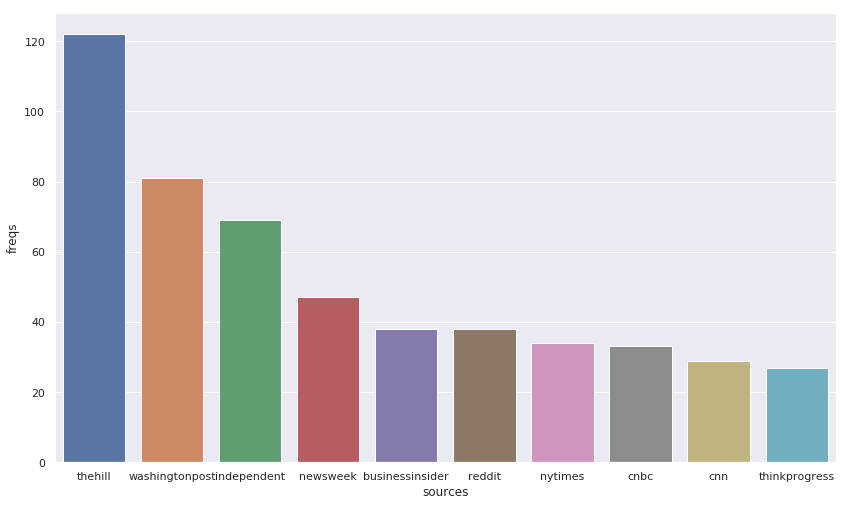

In [0]:
sns.set(rc={'figure.figsize':(14,8.27)})
sns.barplot(x='sources', y='freqs',data=df_sources)

Here I defined a custom class "Comment" that has a body, score, and sum_comm (total number of comments in the post) field. I found that iterating through the comments of all of the top posts took too much time, so I limited the comment analysis to the top 100 posts. 

The first comment in each post is an auto-generated bot reminder of the rules and guidelines of the subreddit. Therefore, the top comment in each post is the second comment in comments.list().

For each of the top 100 posts, create a new Comment instance and add that instance to the set of comments.

In [0]:
class Comment:
  def __init__(self, body, score, sum_comm):
    self.body = body
    self.score = score
    self.sum_comm = sum_comm  

top_100_posts = politics.top(limit=100)
comments = set()

for post in top_100_posts:
  c = post.comments.list()[1]
  com = Comment(c.body, c.score, post.num_comments)
  comments.add(com)

print(len(comments))

100


Create two lists of the scores and the sum_comm for each of the comments and then create a dictionary mapping scores to sum_comms. Also create two lists of the log of the scores and sum_comm for each of the comments and then create a dictionary mapping log scores to log sum_comms.

In [0]:
scores = []
sum_comm = []
com_bodies = set()

log_scores = []
log_sum_comm = []

for comment in comments:
  scores.append(comment.score)
  sum_comm.append(comment.sum_comm)
  log_scores.append(math.log(comment.score))
  log_sum_comm.append(math.log(comment.sum_comm))
  com_bodies.add(comment.body)

dict_comments = {
    "scores": scores,
    "sum_comm": sum_comm
}

dict_comments_log = {
    "log_scores": log_scores,
    "log_sum_comm": log_sum_comm
}

df_comments = pd.DataFrame(dict_comments)
df_comments_log = pd.DataFrame(dict_comments_log)

df_comments.head()

,scores,sum_comm
0,7451,1955
1,2850,1558
2,1541,6959
3,1762,14326
4,7724,6369


Plot a scatter plot of the sum_comms against scores. As the plot shows, there is a weak negative relationship. Therefore, as the number of comments in a post increases, the score of the top comment decreases. This would indicate that posts that generate more comments have less consensus (less people agree with the top comment).

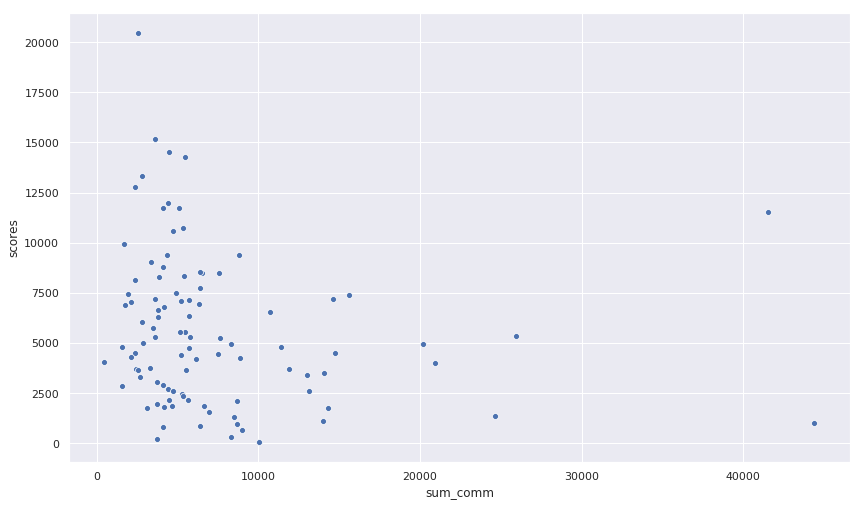

In [0]:
sns.scatterplot(x="sum_comm", y="scores", data=df_comments)

By plotting the log of both sides, we see that the variance decreases as the sum_comm increases, supporting the proposition that there is a weakly negative relationship.

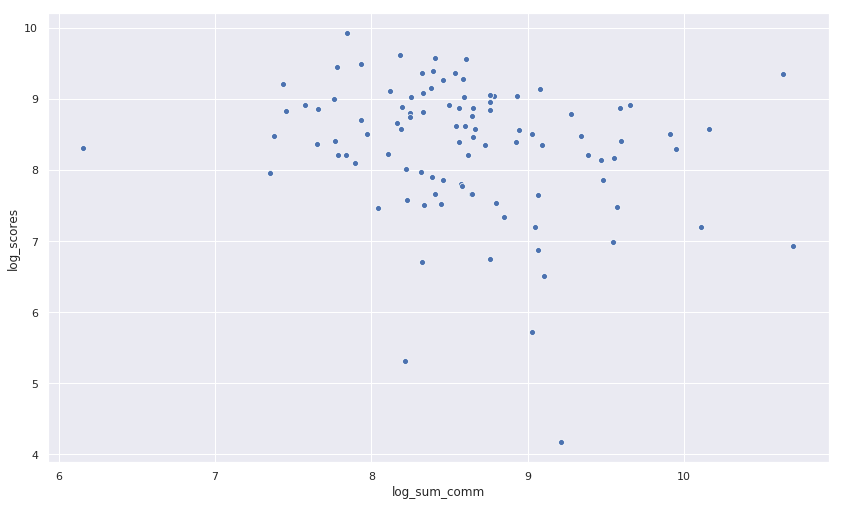

In [0]:
sns.scatterplot(x="log_sum_comm", y="log_scores", data=df_comments_log)

Calculate sentiment analysis of comments following the same steps used for titles.

In [0]:
results = []

for line in com_bodies:
    pol_score = sia.polarity_scores(line)
    pol_score['comment'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'comment': '> "I did try and fuck her. She was married… I moved on her like a bitch, but I '
             "couldn't get there. And she was married. Then all of a sudden I see her, she's not "
             "got the big phony tits and everything... I've got to use some Tic-Tacs, just in case "
             "I start kissing her. You know I'm automatically attracted to beautiful. I just start "
             "kissing them. It's like a magnet. Just kiss. I don't even wait. And when you're a "
             'star, they let you do it. You can do anything. Grab them by the pussy. You can do '
             'anything."',
  'compound': 0.9746,
  'neg': 0.061,
  'neu': 0.697,
  'pos': 0.242},
 {'comment': 'Remember too that the campaign revised the GOP platform, softening the stance on '
             'Ukraine.',
  'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'comment': 'Next press conference. \n'
             '\n'
             'Media outlet called on\n'
             '>You recently

In [0]:
df_comments = pd.DataFrame.from_records(results)
df_comments.head()

,comment,compound,neg,neu,pos
0,"> ""I did try and fuck her. She was married… I ...",0.9746,0.061,0.697,0.242
1,Remember too that the campaign revised the GOP...,0.0000,0.000,1.000,0.000
2,Next press conference. \n\nMedia outlet called...,-0.7299,0.095,0.867,0.038
3,"Breitbart, One America Network, Washington Tim...",-0.6705,0.143,0.857,0.000
4,"> ""You give us $15, and we’ll send six America...",0.3400,0.080,0.788,0.132


In [0]:
df_comments['label'] = 0
df_comments.loc[df_comments['compound'] > 0.2, 'label'] = 1
df_comments.loc[df_comments['compound'] < -0.2, 'label'] = -1
df_comments.head()

,comment,compound,neg,neu,pos,label
0,"> ""I did try and fuck her. She was married… I ...",0.9746,0.061,0.697,0.242,1
1,Remember too that the campaign revised the GOP...,0.0000,0.000,1.000,0.000,0
2,Next press conference. \n\nMedia outlet called...,-0.7299,0.095,0.867,0.038,-1
3,"Breitbart, One America Network, Washington Tim...",-0.6705,0.143,0.857,0.000,-1
4,"> ""You give us $15, and we’ll send six America...",0.3400,0.080,0.788,0.132,1


In [0]:
df_comments_labeled = df_comments[['comment', 'label']]
df_titles_labeled.to_csv('reddit_comments_labels.csv', mode='a', encoding='utf-8', index=False)

print("Positive comments:\n")
pprint(list(df_titles[df_titles['label'] == 1].title)[:3], width=200)

print("\nNegative comments:\n")
pprint(list(df_titles[df_titles['label'] == -1].title)[:3], width=200)

Positive comments:

['> "I did try and fuck her. She was married… I moved on her like a bitch, but I couldn\'t get there. And she was married. Then all of a sudden I see her, she\'s not got the big phony tits and '
 "everything... I've got to use some Tic-Tacs, just in case I start kissing her. You know I'm automatically attracted to beautiful. I just start kissing them. It's like a magnet. Just kiss. I don't "
 'even wait. And when you\'re a star, they let you do it. You can do anything. Grab them by the pussy. You can do anything."',
 '> "You give us $15, and we’ll send six America-saving surprises right to your doorstep," the company said. "It will be fun, it will be weird, and if you voted for Trump, you might want to sit this '
 'one out."\n'
 '\n'
 'Oh shit. I bet I know what they are doing. They are selling ownership of this land - or shares of it. \n'
 '\n',
 '*[In a 2004 interview, Trump told CNN\'s Wolf Blitzer: "In many cases, I probably identify more as Democrat," explainin

In [0]:
print(df_comments.label.value_counts())

print(df_comments.label.value_counts(normalize=True) * 100)

 1    34
-1    32
 0    31
Name: label, dtype: int64
 1    35.051546
-1    32.989691
 0    31.958763
Name: label, dtype: float64


Interestingly, there seems to be a much more even distribution of polarity of the top 100 posts' top comments than top post titles.

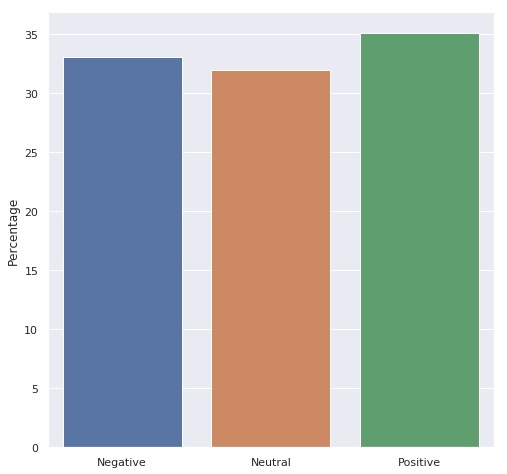

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df_comments.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()